In [68]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.dummy
import sklearn.metrics
import sklearn.neural_network
import sklearn.ensemble

Fetch the data frames from the files

In [ ]:
# read both the matches and the frames
training_df = pd.read_csv('../data/processed/diff_train.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
test_df = pd.read_csv('../data/processed/diff_test.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
# Reinterpret all values as int32s
training_df = training_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})
test_df = test_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})



Helper functions to format the data prior to training

In [51]:

def plot_data(X, y):
    """Plots the data from Exercise 1"""
    plt.scatter(*X[y==-1].T, marker="x", c="r")
    plt.scatter(*X[y==1].T, marker="x", c="b")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.gca().set_aspect('equal')  

def plot_rf_prediction(model):
    """
    Plots the model's predictions over all points in range 2D [-3, 3].
    Assumes at most 3 classes.
    """
    extent = (0, 1, 0, 1)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.predict(X).reshape(x1.shape)
    cmap = matplotlib.colors.ListedColormap(['r', 'b', 'g'])
    plt.imshow(y, extent=extent, origin='lower', alpha=0.4, vmin=0, vmax=2, cmap=cmap, interpolation='nearest')
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    plt.gca().set_aspect('equal')

def scale_data(X_trn, X_tst):
    # Scale the data with MinMax to avoid negative values
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)

    return X_trn, X_tst

def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    # Your implementation here. Aim for 1-4 lines.
    scores = [0 for _ in range(len(estimators))]
    for x in range(len(estimators)):
        scores[x] = sklearn.metrics.accuracy_score(y, estimators[x].predict(X))
        print(sklearn.metrics.precision_recall_fscore_support(y, estimators[x].predict(X), average='binary'))
    return scores

def plot_estimator_scores(estimators, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    # Your implementation here. Use as many lines as you need
    plt.figure()
    X = np.arange(0, len(param_vals))
    trn_scores = score_estimators(X_trn, y_trn, estimators)
    tst_scores = score_estimators(X_tst, y_tst, estimators)
    index = np.argmin(trn_scores - tst_scores)
    print(tst_scores[index])
    plt.title(estimators[0].__class__.__name__ + " score vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.ylim(0.0, 1.05)
    plt.scatter(X[index], tst_scores[index], marker='x', color='black', s=200)
    plt.plot(X, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    plt.plot(X, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    plt.text(0, 0.4,
             "Optimal Test Accuracy = %.2f%% with %s = %d " % (tst_scores[index] * 100, param_name, param_vals[index]))
    plt.legend()
    plt.xticks(X, param_vals)
    

def train_estimators(X, y, estimator_type, param_name, param_vals, **kwargs):
    estimators = [0 for i in range(len(param_vals))]
    for x in range(len(param_vals)):
        estimators[x] = estimator_type(**{param_name: param_vals[x]}, **kwargs).fit(X, y)
        # Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
        print("Training " + estimator_type.__name__ + "(" + param_name + "=%d " % param_vals[x] + " {0}={1} ".format(
            kwargs.keys(), kwargs.values()))
    return estimators


Feature selection: Select an X and y we want to train on

In [ ]:
X_trn = training_df[['kill_advantage','gold_advantage']].values
y_trn = training_df[['winner']].values.T[0]
X_tst = test_df[['kill_advantage','gold_advantage']].values
y_tst = test_df[['winner']].values.T[0]



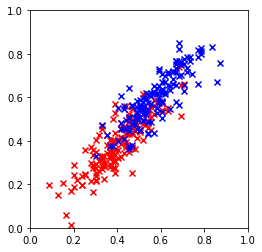

In [48]:
plot_data(X_trn[:300], y_trn[:300])

## Dummy Classifier

In [ ]:

## Here we train a dummy classifier to compare performance
def train_dummy_classifier(X, y):
    dummy_clf = sklearn.dummy.DummyClassifier(strategy='uniform', random_state=0)
    # Scale the data with MinMax to avoid negative values
    dummy_clf.fit(X, y)
    return dummy_clf


## kNN 

In [ ]:
def train_kNN_estimators(X, y):
    param_vals = np.arange(1,6) * 5

    knn_estimators = train_estimators(X, y, sklearn.neighbors.KNeighborsClassifier, 'n_neighbors', param_vals=param_vals)

    plot_estimator_scores(knn_estimators, param_name='n_neighbors', param_vals=param_vals)


## Random Forests

In [63]:
def train_random_forests(X, y):
    estimator = np.arange(1, 5) * 50
    depths = np.arange(1, 5) * 5
    param_grid = {
        'n_estimators': estimator, 
        'max_depth': depths
    }
    clf = sklearn.ensemble.RandomForestClassifier(random_state=0)
    gscv = sklearn.model_selection.GridSearchCV(clf, param_grid=param_grid, verbose=1, cv=3)
    gscv.fit(X, y)
    
    print(gscv.cv_results_)
    
    return gscv.best_estimator_
    


## Neural Network

In [83]:
## This is the neural network trained in Lab 8

def train_neural_network(X, y):
    net = sklearn.neural_network.MLPClassifier(        
        learning_rate_init=0.01,
        momentum=0.9,
        random_state=0,
        verbose=True
    )
    param_grid = [
        {
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [
             (), (1,),(2,),(3,),
            ]
        }
    ]
    gscv = sklearn.model_selection.GridSearchCV(net, param_grid=param_grid, verbose=1, cv=3)
    gscv.fit(X, y)

    return gscv.best_estimator_
train_neural_network(X_trn,y_trn)

(15680, 2)
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Iteration 1, loss = 0.67975992
Iteration 2, loss = 0.65394503
Iteration 3, loss = 0.64025174
Iteration 4, loss = 0.62744581
Iteration 5, loss = 0.61550372
Iteration 6, loss = 0.60434211
Iteration 7, loss = 0.59394855
Iteration 8, loss = 0.58423548
Iteration 9, loss = 0.57510189
Iteration 10, loss = 0.56654467
Iteration 11, loss = 0.55856361
Iteration 12, loss = 0.55101141
Iteration 13, loss = 0.54389842
Iteration 14, loss = 0.53727232
Iteration 15, loss = 0.53097686
Iteration 16, loss = 0.52510123
Iteration 17, loss = 0.51951399
Iteration 18, loss = 0.51425465
Iteration 19, loss = 0.50923013
Iteration 20, loss = 0.50451989
Iteration 21, loss = 0.50003258
Iteration 22, loss = 0.49578168
Iteration 23, loss = 0.49176602
Iteration 24, loss = 0.48798216
Iteration 25, loss = 0.48426453
Iteration 26, loss = 0.48075867
Iteration 27, loss = 0.47746204
Iteration 28, loss = 0.47428984
Iteration 29, loss = 0.47125927
Iteratio

MLPClassifier(activation='tanh', hidden_layer_sizes=(2,),
              learning_rate_init=0.01, random_state=0, solver='sgd',
              verbose=True)

## Evaluation

Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'mean_fit_time': array([0.21886595, 0.40351486, 0.59556667, 0.78610365, 0.25769265,
       0.54649464, 0.83085903, 1.12065236, 0.32478468, 0.66416907,
       0.99838114, 1.36088077, 0.34816416, 0.71597894, 1.05228972,
       1.35137105]), 'std_fit_time': array([0.02164036, 0.01227785, 0.02530283, 0.01626275, 0.00456116,
       0.01367742, 0.00880096, 0.02506413, 0.00310483, 0.02299487,
       0.024675  , 0.03617472, 0.00288785, 0.0052021 , 0.00754718,
       0.03227042]), 'mean_score_time': array([0.02196924, 0.04387776, 0.06342204, 0.07663337, 0.02781526,
       0.05535237, 0.08046508, 0.10912172, 0.03407804, 0.06600746,
       0.10362546, 0.13431478, 0.03797301, 0.07280588, 0.10687526,
       0.1418616 ]), 'std_score_time': array([0.0013889 , 0.001975  , 0.00472141, 0.0009819 , 0.0017469 ,
       0.00042229, 0.00070675, 0.00192635, 0.00254704, 0.00223741,
       0.00449688, 0.00168412, 0.00189671, 0.0030093 , 0.00235423,
 

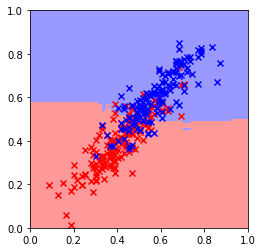

In [65]:

X_trn, X_tst = scale_data(X_trn, X_tst)
# train_neural_network(X, y)
# train_kNN_estimators(X_trn, X_tst, y_trn, y_tst)
rf_clf = train_random_forests(X_trn, y_trn)

dm_clf = train_dummy_classifier(X_trn, y_trn)
y_pred = dm_clf.predict(X_tst)
stats = sklearn.metrics.precision_recall_fscore_support(y_tst, y_pred, average='binary')
sklearn.metrics.accuracy_score(y_tst, y_pred)
plt.figure()
plot_data(X_trn[:300], y_trn[:300])
plot_rf_prediction(rf_clf)